In [1]:
# !pip install graphviz

In [2]:
def f(x):
    return 3*x**2 + 2*x + 10

In [3]:
# calculate derivative
def derivative_f(x):
    h = 0.00000001
    return (f(x+h) - f(x))/h
    

In [4]:
# calculate derivative at x=-1/4

derivative_f(-1/4)

0.5000000413701855

In [5]:
# derivative is zero at x=-1/3

derivative_f(x=-1/3)

1.7763568394002505e-07

In [6]:
# implement value object that supports mathematical operations like sum and multiply and back tracks on grad and calculation

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
    
    def __repr__(self):
        return "Value(data={})".format(self.data)
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
        

In [7]:
a = Value(6.0, label='a')
b = Value(10.0, label='b')
c = Value(4.0, label='c')
e = a*b; e.label = 'e'
d = e + c ;d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

In [8]:
# Display graphical representation of value

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s |data %.4f | grad %.4f  }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

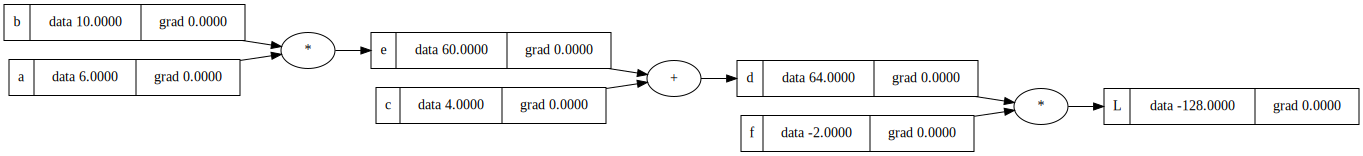

In [9]:
draw_dot(L)

In [10]:
# fill in grad manually for backward pass

L.grad = 1.0
d.grad = -2.0
f.grad = 64.0
e.grad = -2.0
c.grad = -2.0
a.grad = -2.0 * 10.0
b.grad = -2.0 * 6.0

In [11]:
#calculate grad locally

def lol():
    h = 0.0001
    a = Value(6.0, label='a')
    b = Value(10.0, label='b')
    c = Value(4.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c ;d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(6.0, label='a')
    b = Value(10.0, label='b')
    b.data+=h
    c = Value(4.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c ;d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data
    
    return (L2-L1)/h

    
lol()    

-11.999999999829924

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import math

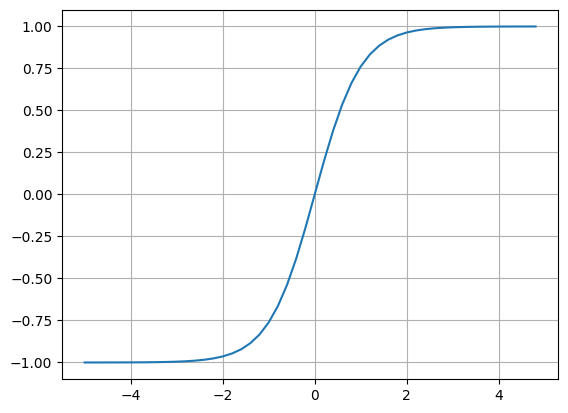

In [13]:
# Tanh can be used as squashing function
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [14]:
# Add new operations for accommodate tanh calculation 

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda : None
        self._op = _op
        self.label = label
        self.grad = 0
    
    def __repr__(self):
        return "Value(data={})".format(self.data)
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t , (self, ), "tanh")

        def _backward():
            self.grad = (1-t**2) * out.grad
            
        out._backward = _backward
        return out

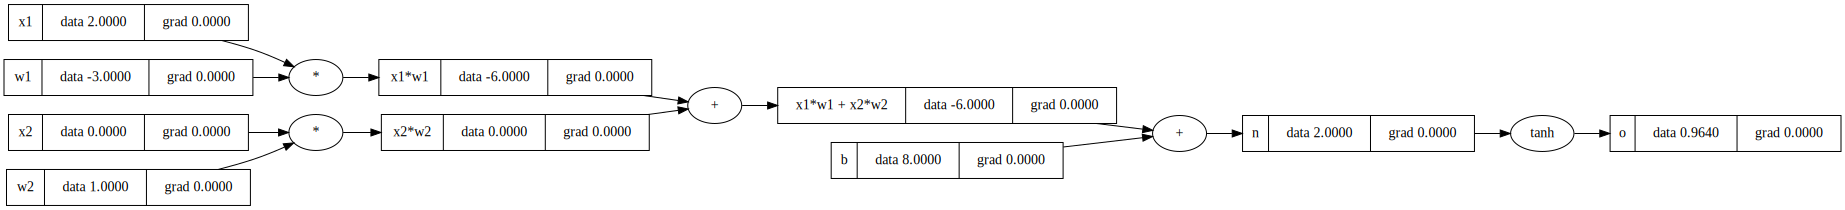

In [15]:
# Another example of backpropagation using nearon of type wx+b

#input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w1
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(8, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Final Neuron
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = "o"

draw_dot(o)

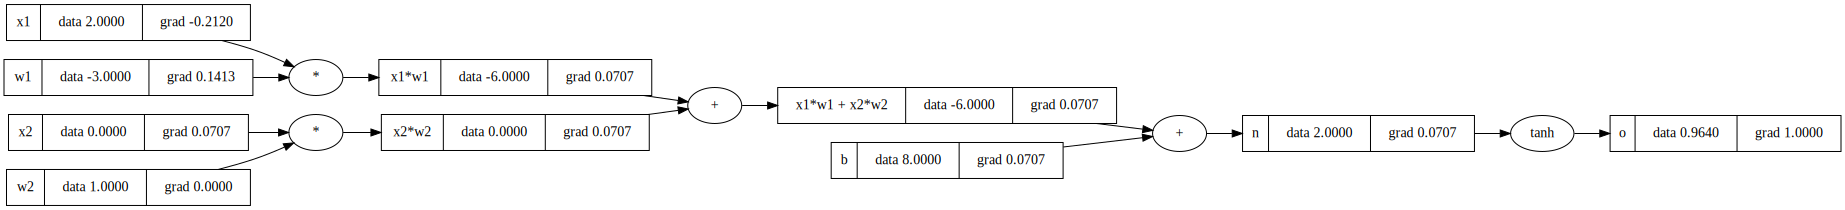

In [16]:
# fill in gradients for back propagation manually
o.grad = 1.0

#do/dn = 1- o**2
n.grad = (1-(o.data**2))

#do/db = do/dn * dn/db; n = z + b; dn/db=1
b.grad = n.grad
x1w1x2w2.grad = n.grad

# do/dx1w1  = do/dn * dx1w1x2w1/dx2w2 * dn/dx1w1x2w2
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

draw_dot(o)

In [17]:
# fill in grad i.e. back propogate automatically by calling backward function
o.grad = 1.0
o._backward()

In [18]:
n._backward()

In [19]:
b._backward()

In [20]:
x1w1x2w2._backward()

In [21]:
x1w1._backward()

In [22]:
x2w2._backward()

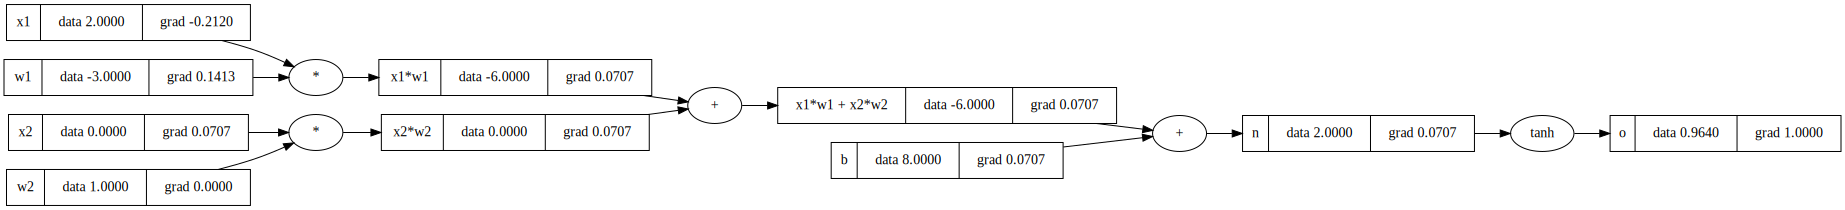

In [23]:
draw_dot(o)

### Use topological sort to call backward in reversed order on each node

In [24]:
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
for node in reversed(topo):
    node._backward()

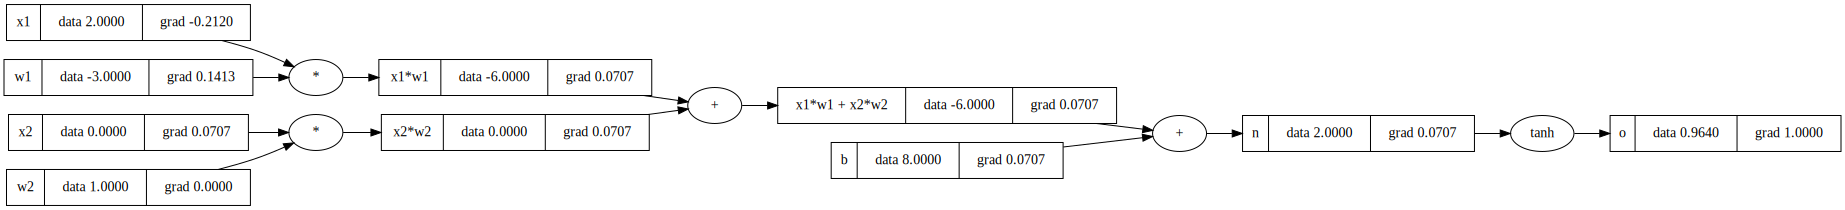

In [25]:
draw_dot(o)

#### Add backward function in Value Class

In [26]:
# Add new operations for accommodate tanh calculation 

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda : None
        self._op = _op
        self.label = label
        self.grad = 0
    
    def __repr__(self):
        return "Value(data={})".format(self.data)
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t , (self, ), "tanh")

        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

### Fixing the accumulation bug. Gradients should not reset but update

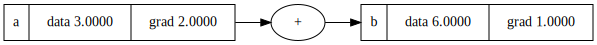

In [27]:
a = Value(3.0, label="a")
b = a+a; b.label = "b"
b.backward()
draw_dot(b)

### Break down tanh in simple function

In [28]:
# Add new operations for accommodate tanh calculation 

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda : None
        self._op = _op
        self.label = label
        self.grad = 0
    
    def __repr__(self):
        return "Value(data={})".format(self.data)
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other ** -1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supports int and float"
        out = Value(self.data**other, (self, ), f'**(other)')

        def _backward():
            self.grad = other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
        

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t , (self, ), "tanh")

        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        return out

    def exp(self):
        n = self.data
        out = Value(math.exp(n), (self, ), "exp")

        def _backward():
            self.grad =out.data * out.grad
        out._backward = _backward
        return out

    

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [52]:
a = Value(1.0)
b = Value(2.0)
a-b
a.exp()

Value(data=2.718281828459045)

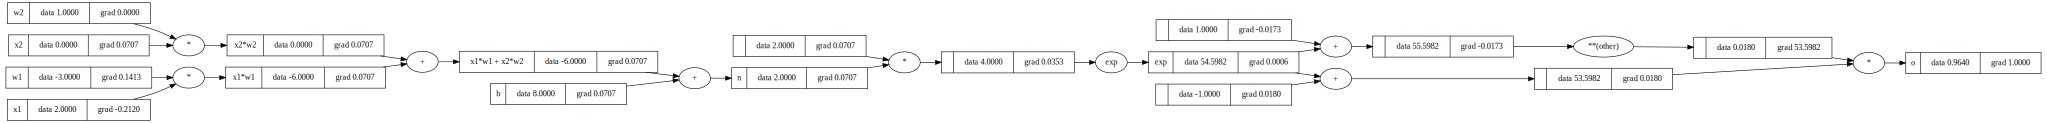

In [30]:
# Another example of backpropagation using nearon of type wx+b

#input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w1
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(8, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Final Neuron
n = x1w1x2w2 + b; n.label = 'n'


# Smooth Function ( redefine tanh)
e = (2*n).exp(); e.label = "exp"
o = (e-1)/(e+1); o.label = "o"
# o = n.tanh(); o.label = "o"
o.backward()
draw_dot(o)

### Reimplement same in PyTorch

In [31]:
import torch

In [32]:
# Implement same in pytorch and double check the results from above

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([8]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('X1 grad: ', x1.grad.item())
print('w1 grad: ', w1.grad.item())
print('X2 grad: ', x2.grad.item())
print('w2 grad: ', w2.grad.item())

0.9640275800758169
X1 grad:  -0.2119524745594933
w1 grad:  0.14130164970632886
X2 grad:  0.07065082485316443
w2 grad:  0.0


### Multi-Layer Perceptron

In [33]:
import random

In [34]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
        
    def __call__(self, x):
        result = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) 
        out = result.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [ Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [ p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
            
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [ Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [35]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.5323076598268071)

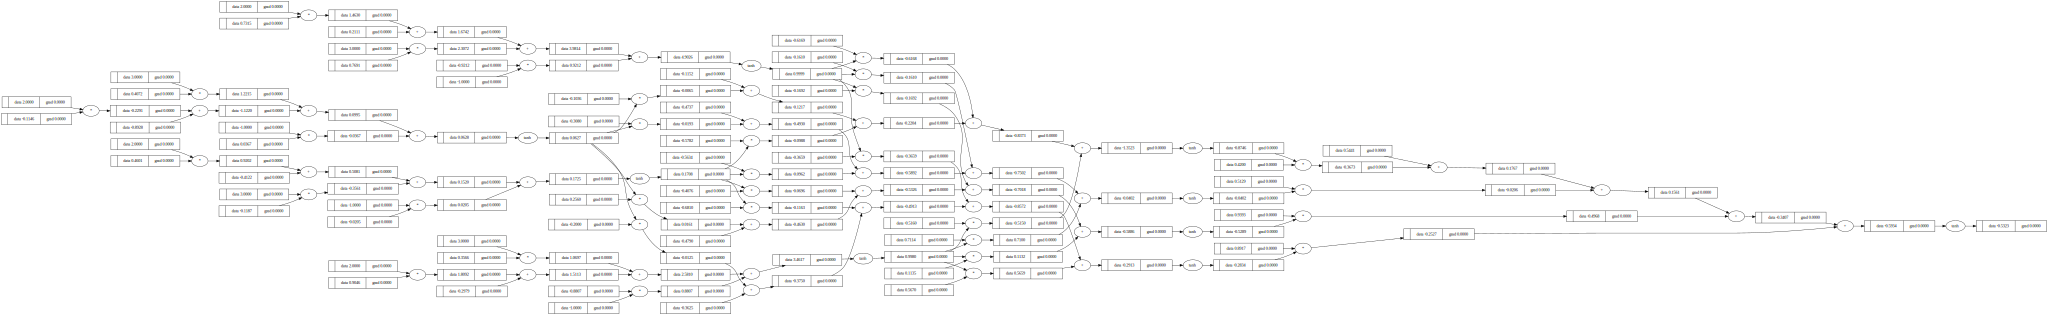

In [36]:
draw_dot(n(x))

In [37]:
n = MLP(3, [4,4,1])
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]

ypred

[Value(data=-0.5261370376533931),
 Value(data=-0.6765343187403343),
 Value(data=-0.6052519750160136),
 Value(data=-0.5695408114962498)]

In [38]:
n.parameters()

[Value(data=0.8667629556354761),
 Value(data=0.33817745959006795),
 Value(data=0.1575361057232587),
 Value(data=0.7159194236119577),
 Value(data=0.6517597589426656),
 Value(data=-0.8648744945377795),
 Value(data=-0.3620767403815912),
 Value(data=-0.9007256958940535),
 Value(data=-0.5383700922530443),
 Value(data=-0.049693324117243254),
 Value(data=0.8179847905299384),
 Value(data=-0.2087930812263552),
 Value(data=-0.6841857247707137),
 Value(data=0.0486844553041037),
 Value(data=0.027827242358253068),
 Value(data=-0.03382227044933006),
 Value(data=-0.044514908623623395),
 Value(data=-0.5846630802256669),
 Value(data=0.6183090028017977),
 Value(data=0.5597504434898093),
 Value(data=-0.43191727943077485),
 Value(data=-0.03083968775891588),
 Value(data=0.7950005598810728),
 Value(data=-0.6122017138015026),
 Value(data=-0.7394380734281811),
 Value(data=-0.32953503134451223),
 Value(data=0.5928862537761708),
 Value(data=0.6321605853781052),
 Value(data=-0.15228650718428494),
 Value(data=-0.

In [39]:
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.053008666831317)

In [40]:
loss.backward()

In [41]:
n.layers[0].neurons[0].w[1]

Value(data=0.33817745959006795)

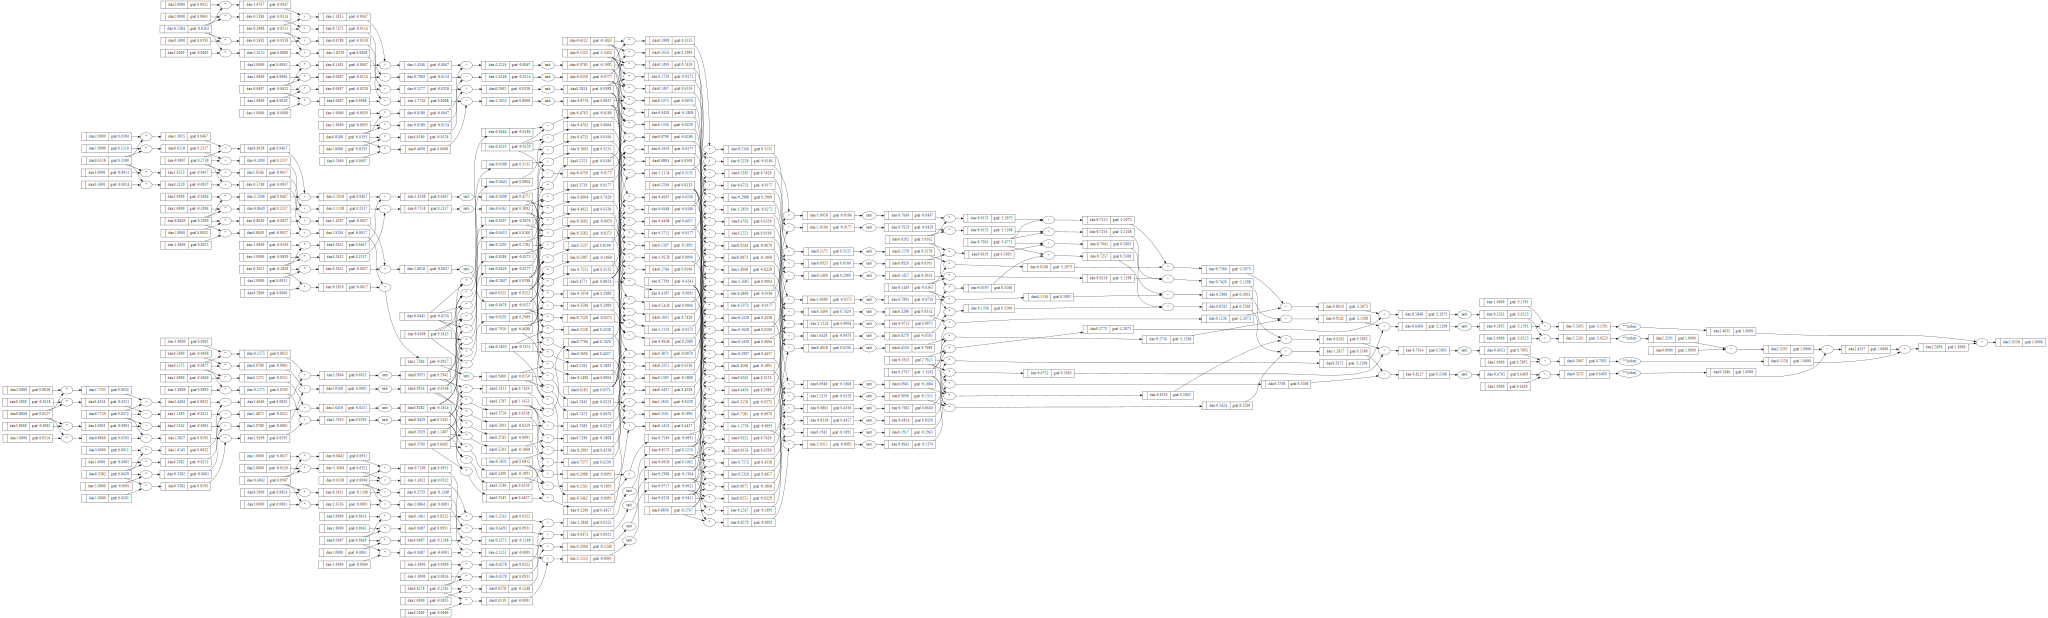

In [42]:
draw_dot(loss)

In [43]:
n.parameters()[0].grad

0.0526782864498707

In [44]:
for p in n.parameters():
    p.data += -0.001 * p.grad

In [45]:
def train(steps=10, print_mod=10, alpha=0.001): 
    for k in range(steps):
        
        # forward pass
        ypred = [n(x) for x in xs]
        loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
        
        # backward pass
        for p in n.parameters():
            p.grad = 0.0
        loss.backward()
        
        # update
        for p in n.parameters():
            p.data += -alpha * p.grad
        
        if(k%print_mod == 0):  
            print(k, loss.data)
    

In [46]:
train(10000, print_mod=1000, alpha=0.01)

0 5.0115106136201995
1000 0.006469975790557345
2000 0.0028488757107770347
3000 0.0017904397278968747
4000 0.0012948758462711053
5000 0.0010098684074770835
6000 0.0008255769453527564
7000 0.0006969940338327323
8000 0.0006023553955765472
9000 0.0005298841870387927


In [47]:
[n(x) for x in xs]

[Value(data=0.992090036650481),
 Value(data=-0.9861619434785197),
 Value(data=-0.9896494876291239),
 Value(data=0.9894419357334368)]

In [48]:
import requests

In [49]:
response = requests.get('https://boards.greenhouse.io/circlereferrals/jobs/7014056002')

In [50]:
response.text

'<!DOCTYPE html>\n<html lang="en">\n<head prefix="og: http://ogp.me/ns#">\n<script>var _rollbarConfig = {"accessToken":"a9e544e2eb674f56b12d47e1d2ed4cd1","captureUncaught":true,"payload":{"environment":"production"},"hostBlockList":["linkedin.com","recruitics.com"],"checkIgnore":function(isUncaught, args, payload) {\n  try {\n    var isPhantomJS = window.navigator.userAgent.match(/phantomjs/i);\n    var isSplash= window.navigator.userAgent.match(/splash version/i);\n    var firefox = window.navigator.userAgent.match(/(firefox)\\/(\\w+)/i); // JSON, must escape slash\n    var chrome = window.navigator.userAgent.match(/(chrome)\\/(\\w+)/i); // JSON, must escape slash\n\n    var browserExtensionOrAutomationFile = function(frame) {\n      var regExPatterns = [/^chrome-extension/, /^safari-extension/, /^moz-extension/, /^pptr/];\n      return regExPatterns.some(function(regEx) {\n        return regEx.test(frame.filename);\n      });\n    }\n\n    var isBrowserExtensionOrAutomation = payload

In [51]:
"Over the past year," in response.text

True